[View in Colaboratory](https://colab.research.google.com/github/krislars/astropy-tutorials/blob/fix_testing/tutorials/notebooks/color-excess/color-excess.ipynb)

# Dereddening a spectrum and calculating reddening

Kristen Larson (@krislars) with ideas Emir Karamehmetoglu and feedback from Pey Lian Lim, Karl Gordon, and Kevin Covey.

June 2018

## Learning Goals
- Investigate extinction curve shapes
- Deredden spectral energy distributions and spectra
- Calculate photometric extinction and reddening
- Use `dust_extinction` and `synphot` together





## Keywords
`dust_extinction`,  `synphot`

# Introduction

Dust in the interstellar medium (ISM) extinguishes background starlight.  The wavelength dependence of the extinction is such that short-wavelength light is extinguished more than long-wavelength light, and we call this effect *reddening*.

If you're new to extinction, here is a brief introduction to the types of quantities involved.
The fractional change to the flux of starlight is 
$$
\frac{dF_\lambda}{F_\lambda} = -\tau_\lambda
$$
where $\tau$ is the optical depth and depends on wavelength.  Integrating along the line of sight, the resultant flux is an exponential function of optical depth,
$$
\tau_\lambda = -\ln\left(\frac{F_\lambda}{F_{\lambda,0}}\right).
$$

With an eye to how we define magnitudes, we usually change the base from $e$ to 10,  
$$
\tau_\lambda = -2.303\log\left(\frac{F_\lambda}{F_{\lambda,0}}\right),
$$
and define an extinction $A_\lambda = 1.086 \,\tau_\lambda$ so that
$$
A_\lambda = -2.5\log\left(\frac{F_\lambda}{F_{\lambda,0}}\right).
$$


There are two basic take-home messages from this derivation:

* Extinction introduces a multiplying factor $10^{-0.4 A_\lambda}$ to the flux.
* Extinction is defined relative to the flux without dust, $F_{\lambda,0}$.

In this tutorial, we will look at some extinction curves from the literature, use one of those curves to deredden an observed spectrum, and practice invoking a background source flux in order to calculate magnitudes from an extinction model.

## Installation

In [0]:
# Standard imports:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

This tutorial uses two of the affiliated packages of astropy, `dust_extinction` and `synphot`.  You will find instructions on how to [install affiliated packages here](https://www.astropy.org/affiliated/).  You can also use pip as demonstrated in the commented-out cell below.

In [2]:
# For running in Google Colaboratory, uncomment these lines:
# !pip install astropy
!pip install dust_extinction
# !pip install synphot
# !pip install astroquery

Once astropy and the affiliated packages are installed, we can import from them as needed:

In [0]:
import astropy.units as u
from astropy.table import Table
from dust_extinction.dust_extinction import CCM89, F99
from synphot import units
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.reddening import ExtinctionCurve
from astroquery.simbad import Simbad
from astroquery.mast import Observations

# Example 1: Investigate Extinction Models

The `dust_extinction` package provides various models for extinction $A_\lambda$ normalized to $A_V$.  The shapes of normalized curves are relatively (and perhaps surprisingly) uniform in the Milky Way.  What variation there is is often parameterized by the ratio of extinction to reddening in the blue-visual,
$$
R_V = \frac{A_V}{E_{B-V}}
$$
where reddening $E_{B-V}$ is differential extinction $A_B-A_V$.  In this example, we show the $R_V$-parameterization for the Clayton, Cardelli, & Mathis (1989, CCM) and the Fitzpatrick (1999) models; see the package documentation for more options.

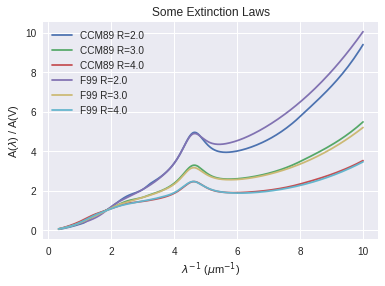

In [4]:
# Create wavelengths array.
wav = np.arange(0.1, 3, 0.001)*u.micron

for model in [CCM89,F99]:
    for R in (2.0,3.0,4.0):
      # Initialize the extinction model.
      ext = model(Rv=R)
      plt.plot(1/wav, ext(wav), label=model.name+' R='+str(R))

plt.xlabel('$\lambda^{-1}$ ($\mu$m$^{-1}$)')
plt.ylabel('A($\lambda$) / A(V)')
plt.legend(loc='best')
plt.title('Some Extinction Laws')
plt.show()

Astronomers studying the ISM often display extinction curves against inverse wavelength (wavenumber) to show the ultraviolet variation, as we do here.  Infrared extinction varies much less and approaches zero at long wavelength in the absence of grey or wavelength-independent extinction.

# Example 2: Deredden a Spectrum

Here we deredden (unextinguish) the IUE ultraviolet spectrum of the star $\rho$ Oph (HD 147933) with optical flux of the star from Simbad photometry.

First, we fetch the spectrum from the IUE archive:

In [5]:
obsTable = Observations.query_object("HD 147933",radius="1 arcsec")
obsTable_spec=obsTable[obsTable['dataproduct_type']=='spectrum']
# obsTable_spec.pprint()

obsids = ['3000022829']
dataProductsByID = Observations.get_product_list(obsids)
manifest = Observations.download_products(dataProductsByID)

INFO: Found cached file ./mastDownload/IUE/lwr05639/lwr05639.mxlo.gz with expected size 18165. [astroquery.query]
INFO: Found cached file ./mastDownload/IUE/lwr05639/lwr05639mxlo_vo.fits with expected size 48960. [astroquery.query]


We read the downloaded files into an astropy table:

In [6]:
t_lwr = Table.read('./mastDownload/IUE/lwr05639/lwr05639mxlo_vo.fits')
t_lwr

WAVE [562],FLUX [562],SIGMA [562],QUALITY [562]
Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),
float32,float32,float32,int16
1851.4327 .. 3348.901,2.08651e-10 .. 7.39839e-11,4.2679475e-11 .. 1.347232e-10,0 .. 16


The next lines read columns of the table into quantity numpy vectors.  Quantities attach units to the values.

In [0]:
wav_UV = t_lwr['WAVE'][0,].quantity
UVflux = t_lwr['FLUX'][0,].quantity

Now, we fetch some photometry from Simbad to go with the IUE spectrum:

In [0]:
custom_query = Simbad()
custom_query.add_votable_fields('fluxdata(U)','fluxdata(B)','fluxdata(V)')
phot_table=custom_query.query_object('HD 147933')
Umag=phot_table['FLUX_U']
Bmag=phot_table['FLUX_B']
Vmag=phot_table['FLUX_V']

To convert the photometry to flux, we look up some properties of the photometric passbands:

In [0]:
wav_U = 0.3660 * u.micron 
zeroflux_U_nu = 1.81E-23 * u.Watt/(u.m*u.m*u.Hz)
wav_B = 0.4400 * u.micron
zeroflux_B_nu = 4.26E-23 * u.Watt/(u.m*u.m*u.Hz)
wav_V = 0.5530 * u.micron
zeroflux_V_nu = 3.64E-23 * u.Watt/(u.m*u.m*u.Hz)
# refs: http://ned.ipac.caltech.edu/help/photoband.lst
#       http://ned.ipac.caltech.edu/help/phoresult_help.html

However, we notice that the zero-point fluxes we found for the optical passbands are not in the same units as the IUE fluxes.  To make matters words, the zero-point fluxes are $F_\nu$ and the IUE data are $F_\lambda$.  To convert between them, the wavelength is needed.  Fortunately, astropy provides an easy way to make the conversion with *equivalencies*:

In [0]:
zeroflux_U = zeroflux_U_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_U))
zeroflux_B = zeroflux_B_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_B))
zeroflux_V = zeroflux_V_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_V))

Now it easy to convert from magnitude to flux:

In [0]:
Uflux = zeroflux_U * 10.**(-0.4*Umag)
Bflux = zeroflux_B * 10.**(-0.4*Bmag)
Vflux = zeroflux_V * 10.**(-0.4*Vmag)

We went though the trouble to get the quantities correct so that we can take advantage of astropy's unit support in plotting.  You should try to skip over the unit conversion to see the error that astropy throws if the quantities can't be reconciled.

In [12]:
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7efeed8d82b0>

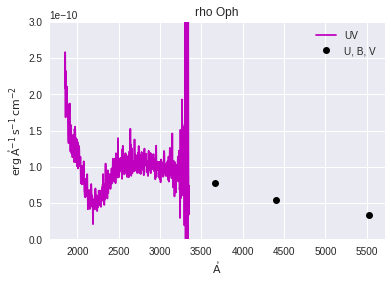

In [13]:
plt.plot(wav_UV,UVflux,'m',label='UV')
plt.plot(wav_V,Vflux,'ko',label='U, B, V')
plt.plot(wav_B,Bflux,'ko')
plt.plot(wav_U,Uflux,'ko')
plt.legend(loc='best')
plt.ylim(0,3E-10)
plt.title('rho Oph')
plt.show()

A-ha! Notice that `quantity_support` converted the wavelengths into the same units. Handy! 

Finally, we initialize the extinction model, choosing a value for $R_V$ and reddening $E_{B-V}$.  This star is famous in the ISM community as an example of a large-$R_V$ line of sight.

In [0]:
Rv = 5.0  # Usually around 3, but about 5 for this star.
Ebv = 0.5
ext = F99(Rv=Rv)

To extinguish (redden) a spectrum, multiply by the `ext.extinguish` function.  To unextinguish (deredden), divide by the same `ext.extinguish`, as we do here:

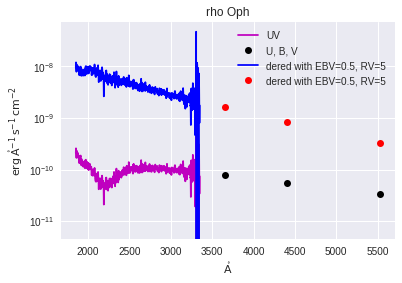

In [15]:
plt.semilogy(wav_UV,UVflux,'m',label='UV')
plt.semilogy(wav_V,Vflux,'ko',label='U, B, V')
plt.semilogy(wav_B,Bflux,'ko')
plt.semilogy(wav_U,Uflux,'ko')

plt.semilogy(wav_UV,UVflux/ext.extinguish(wav_UV,Ebv=Ebv),'b',
             label='dered with EBV=0.5, RV=5')
plt.semilogy(wav_V,Vflux/ext.extinguish(wav_V,Ebv=Ebv),'ro',
             label='dered with EBV=0.5, RV=5')
plt.semilogy(wav_B,Bflux/ext.extinguish(wav_B,Ebv=Ebv),'ro')
plt.semilogy(wav_U,Uflux/ext.extinguish(wav_U,Ebv=Ebv),'ro')

plt.legend(loc='best')
plt.title('rho Oph')
plt.show()

Notice that the absorption feature at 2175 Angstrom is removed.  This feature can also be seen as the prominent bump in the extinction curves in Example 1.

Those experienced with dereddening should notice that that `dust_extinction` returns $A_\lambda/A_V$, while other routines like the IDL `fm_unred` procedure often return $A_\lambda/E_{B-V}$ by default and need to be divided by $R_V$ in order to compare directly with `dust_extinction`.

# Example 3: Calculate Color Excess with `synphot`

Calculating broadband *photometric* extinction is harder than it might look at first.  All we have to do is look up $A_\lambda$ for a particular band, right?  Under the right conditions, yes.  In general, no.

Remember that we have to integrate over a passband to get synthetic photometry,
$$
A = -2.5\log\left(\frac{\int W_\lambda F_{\lambda,0} 10^{-0.4A_\lambda} d\lambda}{\int W_\lambda F_{\lambda,0} d\lambda} \right),
$$
where $W_\lambda$ is the fraction of incident energy transmitted through a filter.  See the detailed appendix in Bessell & Murphy (2012) for an excellent review of the issues and common misunderstandings in synthetic photometry.

There is an important point to be made here. The expression above does not simplify any further. Strictly speaking, it is impossible to convert spectral extinction $A_\lambda$ into a magnitude system without knowing the wavelength dependence of the source's original flux across the filter in question.  As a special case, if we assume that the source flux is constant in the band (i.e. $F_\lambda = F$), then we can cancel these factors out from the integrals, and extinction in magnitudes becomes the weighted average of the extinction factor across the filter in question. In that special case, $A_\lambda$ at $\lambda_{\rm eff}$ is a good approximation for magnitude extinction.

In this example, we will demonstrate the more rigorous calculation.  We use a blackbody curve for the flux before the dust, apply an extinction curve, and perform synthetic photometry to calculate extinction and reddening in a magnitude system.


First, let's get the filter transmission curves:

In [0]:
# Optional, for when the STScI ftp server is not answering:
from synphot import config
config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_k_003_syn.fits'

u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')

The lines above get the filter transmission curves from an FTP server at STScI.  If FTP server is not responding, uncomment out the optional lines to use an http server instead.

If you are running this with your own python, see the [synphot documentation](https://synphot.readthedocs.io/en/latest/#installation-and-setup) on how to download your own copy of the necessary files.

Next, let's make a background flux to which we will apply extinction.  Here we make a 10,000 K blackbody using the model mechanism from within `synphot` and normalize it to $V$ = 10 in the Vega-based magnitude system.

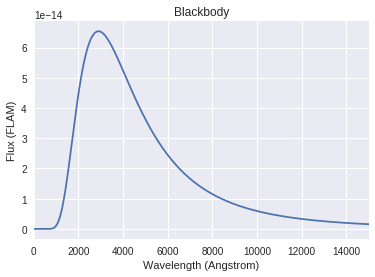

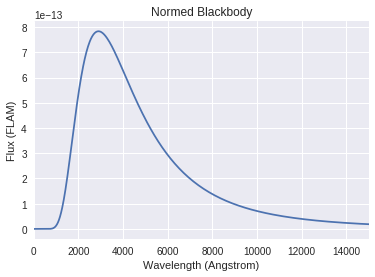

In [17]:
# First, create a blackbody at some temperature.
sp = SourceSpectrum(BlackBodyNorm1D, temperature=10000)
sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Get the Vega spectrum as the zero point flux.
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)

# Normalize the blackbody to some chosen magnitude, say V = 10.
vmag = 10.
v_band = SpectralElement.from_filter('johnson_v')
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit='flam', title='Normed Blackbody')

Now we initialize the extinction model and choose an extinction of $A_V$ = 2.  To get the `dust_extinction` model working with `synphot`, we create a wavelength array and make a spectral element with the extinction model as a lookup table.

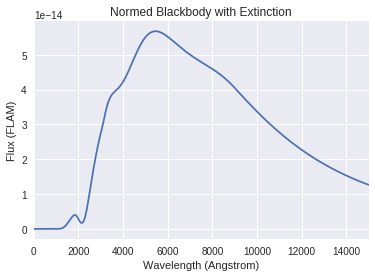

In [18]:
# Initialize the extinction model and choose the extinction, here Av = 2.
ext = CCM89(Rv=3.1)
Av = 2.

# Create a wavelength array. 
wav = np.arange(0.1, 3, 0.001)*u.micron

# Make the extinction model in synphot using a lookup table.
ex = ExtinctionCurve(ExtinctionModel1D, 
                     points=wav, lookup_table=ext.extinguish(wav, Av=Av))
sp_ext = sp_norm*ex
sp_ext.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction')

Hey, there's that feature at 2175 Angstroms again!

Synthetic photometry means sending the astronomical flux through a certain filter:

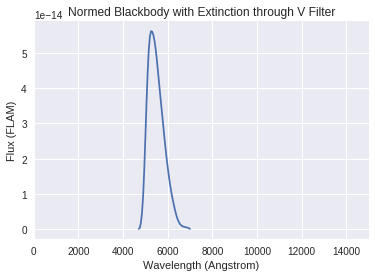

In [19]:
# "Observe" the star through the filter and integrate to get photometric mag.
sp_obs = Observation(sp_ext, v_band)
sp_obs_before = Observation(sp_norm, v_band)
sp_obs.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction through V Filter')

and integrating it to get a flux.  The "effective stimulus" in `synphot` refers to the integrated flux that would be incident on a detector.  Invoking the Vega flux unit will convert the flux to a Vega-based magnitude system. 

In [20]:
sp_stim_before = sp_obs_before.effstim(flux_unit='vegamag', vegaspec=vega)
sp_stim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
print('before dust, V =', np.round(sp_stim_before,1))
print('after dust, V =', np.round(sp_stim,1))

# Calculate extinction and compare to our chosen value.
Av_calc = sp_stim - sp_stim_before
print('$A_V$ = ', np.round(Av_calc,1))

before dust, V = 10.0 VEGAMAG
after dust, V = 12.0 VEGAMAG
$A_V$ =  2.0 VEGAMAG


Ah, good!  We normalized our spectrum to $V$ = 10 mag and added 2 mag of visual extinction, and our synthetic photometry reproduces these chosen values.  We're feeling ready to find the extinction in other passbands. 

We calculate the new photometry for the rest of the Johnson optical and the Bessell infrared filters. We calculate extinction $A = \Delta m$ and plot color excess, $E(\lambda - V) = A_\lambda - A_V$.  

Notice that `synphot` calculates the effective wavelength of the observations for us.  Handy for plotting!

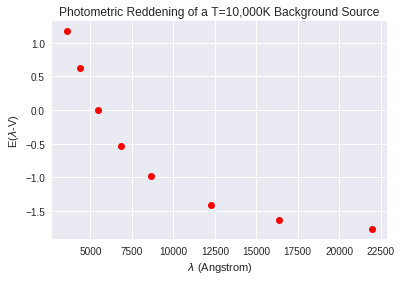

In [21]:
bands = [u_band,b_band,v_band,r_band,i_band,j_band,h_band,k_band]

for band in bands:
    # Calculate photometry with dust:
    sp_obs = Observation(sp_ext, band)
    obs_effstim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
    # Calculate photometry without dust:
    sp_obs_i = Observation(sp_norm, band)
    obs_i_effstim = sp_obs_i.effstim(flux_unit='vegamag', vegaspec=vega)
  
    # Extinction = mag with dust - mag without dust
    # Color excess = extinction at lambda - extinction at V
    color_excess = obs_effstim - obs_i_effstim - Av_calc
    plt.plot(sp_obs_i.effective_wavelength(), color_excess,'or')

plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('E($\lambda$-V)')
plt.title('Photometric Reddening of a T=10,000K Background Source')
plt.show()  

## Exercise
Try changing the blackbody temperature to something very hot or very cool.  Do you get the same color excess?  

The photometric extinction changes because the filter transmission is not uniform, so the throughput of the filter depends on the shape of the background source flux.